# Exercise 1.3.2: Stochastic Gradient Descent
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Create training and validation loops in TensorFlow using the custom functions built in [Exercise 1.3.1](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-3-1-Logistic-Regression/2022-08-27-Logistic-Regression.ipynb);
* Implement the logistic regression model using [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent);
* Train the model on the [German Traffic Sign Recognition Benchmark](https://benchmark.ini.rub.de) dataset.

## 1. Introduction

In [4]:
### Importing required modules

In [5]:
import logging
from matplotlib import patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
import tensorflow as tf
from typing import Callable, List, Tuple

In [6]:
tf.__version__

'2.11.0'

In [7]:
tf.test.gpu_device_name()

Metal device set to: Apple M2 Max


2023-08-17 01:13:18.600628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-17 01:13:18.600678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'


systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [8]:
### Setting environment variables

In [9]:
ENV_COLAB = False                # True if running in Google Colab instance

In [10]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [11]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [12]:
### Unzipping the GTSRB dataset
if ENV_COLAB:
    !unzip -o -q /content/GTSRB.zip -d /content/data/
else:
    !unzip -o -q ./data/GTSRB.zip -d ./data/

In [13]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.1. Custom model functions

We will wrap the cross-entropy loss and accuracy metric functions in a [`tf.keras.metrics.MeanMetricWrapper`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanMetricWrapper) which is a quick way to build a custom metric function in TensorFlow. Since the `MeanMetricWrapper` expects a per-sample loss array as output, we will slightly modify our `cross_entropy` and `accuracy` functions from [Exercise 1.3.1](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-3-1-Logistic-Regression/2022-08-27-Logistic-Regression.ipynb).

#### Softmax activation function

This [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation function is a generalisation of the sigmoid [logistic function](https://en.wikipedia.org/wiki/Logistic_function) to multiple dimensions. The softmax function computes the discrete probability distribution over all classes for each observation in the training step.

#### Cross-entropy loss function

The [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) loss function serves as measure of dissimilarity between the maximum likelihood estimate (the class label prediction) and the corresponding ground truth class label. We will use cross-entropy loss as a cost function to minimise over all data points in our training set.

#### Accuracy scoring metric function

The average number of true class predictions over the total number of predicted class labels. For a single prediction, this value is either $1$ (correct) or $0$ (incorrect).

### 1.2. Modelling with TensorFlow

In this section we will build and prepare the [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model for training and evaluation.

#### Stochastic Gradient Descent algorithm

The logistic regression solver we have selected for this assignment is called [_stochastic gradient descent_](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD). Stochastic gradient descent is used as an iterative optimisation technique for solving the [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) problem when a closed-form solution does not exist (as in logistic regression). In essence, SGD iteratively estimates the parameters of a discrete probability distribution given a set of input observations. _Stochastic_ here implies that a batch size of $1$ is used. That is, on every weight update step only a single training example is used to compute the gradients. This differs from _batch_ or _mini-batch_ gradient descent, which use the full, or subset of the full datasets, on each update step.

The `sgd` function loops over all weight values in vector $\mathrm{w}$ and subtracts the gradient computation from each value $w_{i}$, performing a gradient _descent_ towards the function minima. Here we perform the _stochastic_ approach with `grad` computed on a per-sample basis. With this assumption we will not need to normalise the gradient update with respect to the number of training samples. This yields a gradient computed from the evaluated L2 loss function (a constant value $C$) with respect to the model weights $\mathrm{w}$:
$$
\begin{align}
    \frac{\partial C}{\partial\mathrm{w}} = \frac{2}{N}\sum_{i=1}^{N}\left(\mathrm{w}\cdot \mathrm{x}_{i} + b - y_{i}\right)\mathrm{x}_{i}^{\top}.
\end{align}
$$

Assuming a batch size equal to one training sample, $N = \vert \mathrm{X} \vert = 1$. The worked out derivation of the gradient and an accompanying explanation in much greater detail can be read in Terence Parr's explained.ai article [here](https://explained.ai/matrix-calculus/#sec:1.6.1) [1].

Note that in our implementation of the weight update function we will be combining $\mathrm{w}$ and $b$ into a single vector parameter  $\hat{\mathrm{w}} = \left[\mathrm{w}^{\top}, b\right]^{\top}$. By tacking a $1$ onto the end of our feature vector $\mathrm{x}$ we have $\hat{x} = \left[\mathrm{x}^{\top}, 1\right]$ such that the function $z = \mathrm{x} \cdot \mathrm{w} + b$ becomes $z = \hat{\mathrm{x}}\cdot \hat{\mathrm{w}}$. More on this approach regarding computing the derivative with respect to the bias term be read [here](https://explained.ai/matrix-calculus/#sec:1.6.2).

In summary, the stochastic gradient descent algorithm can be boiled down to a set of four steps:
1. Compute the gradient of the function (finding the slope of the objective function w.r.t. each parameter/feature);
2. Calculate the step size for each feature (product of learning rate and partial derivatives);
3. "Move" the parameter vector values (the weights) in the direction of the steepest descent (subtract the step size from the weights);
4. Repeat steps 1-3 until converged (such that the gradient becomes sufficiently close to zero).

#### Logistic Regression model

Logistic regression is a simple [linear model](https://en.wikipedia.org/wiki/Linear_model) for classification that attempts to fit a mapping between input data $X$ and output labels $y$. To do so, a linear function $y = m*x + b$ is approximated such that two variables $m$ and $b$ minimise the loss. For a linear model such as this, our $m$ variable represents a vector of _weights_ (denoted $\mathrm{W}$) and our $b$ variable represents our _bias_ term. The loss (error) we are attempting to minimise is computed with an off-the-shelf [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) function (commonly referred to as _log loss_). This function produces a loss value which essentially measures the difference between the predicted and true outcome variables.

### 1.3. Training and validation

By utilising several TensorFlow Functional APIs we can perform custom training and validation loops.

**Training loop**:
1. Iterate over training dataset sample-by-sample;
2. Perform the forward pass of the model on each sample:
    * Scale each image data array to values between 0 and 1;
    * Compute the maximum likelihood estimate;
    * Calculate the cross-entropy loss (i.e., measure prediction error);
    * Obtain the gradient with respect to model weight vectors;
    * Update the weight vectors by subtracting the gradient (stochastic gradient descent);
    * Calculate the prediction accuracy;
3. Return the mean average loss and accuracy metrics.


**Validation loop**:
1. Iterate over the validation dataset sample-by-sample;
    * Scale each image data array to values between 0 and 1;
    * Compute the maximum likelihood estimate (i.e., making a prediction);
    * Calculate the prediction accuracy;
2. Return the mean average accuracy metric.

In our `training_loop()` method we will implement the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) tool for performing [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (_autodiff_). TensorFlow's `GradientTape` API uses a reverse-order traversal of operations in the forward and backward passes of a model in order to differentiate a desired function. This is known as _reverse mode differentiation_ and is a more-optimal technique over [symbolic differentiation](https://en.wikipedia.org/wiki/Symbolic_differentiation) and [numerical differentiation](https://en.wikipedia.org/wiki/Numerical_differentiation) for computing the partial derivatives of a function with respect to many inputs.

Here our `GradientTape` routine will calculate the gradient of the loss with respect to the model variables after a forward pass of the model has been run. Once a maximum likelihood estimate has been worked out for an observation $x_{i}$ given its true class label $y = j$ with respect to the weight $w_{j}$, that is,

$$
\begin{align}
    P\left(y = j \vert z_{i} = x_{i}; w_{j} \right) &= \phi_{softmax}\left(z_{i}\right),
\end{align}
$$

where the input $z_{i}$ is defined to be
$$
\begin{align}
    z_{i} = w_{i}x_{i} 
\end{align}
$$

such that $w$ is the model weight vector and $x_{i}$ is the feature vector belonging to the single training observation. 

The gradients computed with `GradientTape` for the cross-entropy loss
$$
\begin{align}
    loss\left(x_{i}, y; w_{i}\right) = H\left(y, \hat{y}\right)
\end{align}
$$

for a one-hot encoded true class label vector $y$ and the corresponding predicted probability distribution $\hat{y}$ are with respect to the model weight and bias parameters $w$ and $b$.

In stochastic gradient descent, these iterative gradient computations are subtracted from the weight vector on a per-sample basis. An unbiased estimate of the _true_ gradient (i.e., gradient computed over the full dataset) using only a single observation can be achieved when sampling the observation uniformly at random over the entire dataset.

Note that the resulting gradient computed by `tf.GradientTape` is in the generalised [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) form.

### 1.4. German Traffic Sign Recognition Benchmark (GTSRB) dataset

The German Traffic Sign Recognition Benchmark is a multi-class, single-image classification challenge created by J. Stallkamp et al. (2012) at the [Institut für Neuroinformatik](https://benchmark.ini.rub.de/gtsrb_news.html) [2]. In this dataset there exists over 50.000 unique images of more than 40 distinct classes of traffic signs. 

Each image has been reliably annotated with the following information:
* **Filename**: filename of the corresponding image;
* **Width**: width of the image;
* **Height**: height of the image;
* **ROI.x1**: x-coordinate of top-left corner of traffic sign bounding box;
* **ROI.y1**: y-coordinate of the top-left corner of traffic sign bounding box;
* **ROI.x2**: x-coordinate of bottom-right corner of traffic sign bounding box;
* **ROI.y2**: y-coordinate of the bottom-right corner of traffic sign bounding box; 
* **ClassId**: assigned class label.

In addition to the CSV-formatted annotations, the following information about the images is provided:
* Images contain one traffic sign each;
* Images contain a border of 10% around the actual traffic sign (at least 5 pixels) to allow for edge-based approaches;
* Images are stored in PPM format ([Portable Pixmap, P6](http://en.wikipedia.org/wiki/Netpbm_format));
* Image sizes vary between 15x15 to 250x250 pixels;
* Images are not necessarily squared;
* The actual traffic sign is not necessarily centred within the image. This is true for images that were close to the image border in the full camera image;
* The bounding box of the traffic sign is part of the annotations.

Lastly, several pre-calculated feature sets are provided. Namely, _Histogram of Oriented Gradients_ (HOG) features, _Haar-like_ features (5 distinct Haar-like features), and _hue histograms_ (256-bin HSV colour space).

This dataset presents unique real-world challenges within object recognition by providing traffic sign images captured in a variety of lighting/illumination conditions and images that have distortions (e.g., blurring, pixelation) as well as differences in shape, size, etc.

For more information on the GTSRB dataset, see [here](https://benchmark.ini.rub.de/gtsrb_dataset.html). 

## 2. Programming Task

### 2.1. Custom model functions

The following functions from [Exercise 1.3.1](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-3-1-Logistic-Regression/2022-08-27-Logistic-Regression.ipynb) have been slightly modified to work on a single input observation.

#### Softmax activation function

In [14]:
### From J. Moran's `2022-08-27-Logistic-Regression.ipynb`

In [15]:
def softmax(logits: tf.Tensor, stable: bool=False) -> tf.Tensor:
    """Returns the softmax probability distribution.
    
    :param logits: a 1xN tf.Tensor of logits.
    :param stable: optional, flag indicating whether
        or not to normalise the input data.
    returns: soft_logits, a 1xN tf.Tensor of real 
        values in range (0,1) that sum up to 1.0.
    """
    
    assert isinstance(logits, tf.Tensor)
    if stable:
        logits = tf.subtract(logits, tf.reduce_max(logits))
    soft_logits = tf.math.exp(logits)
    soft_logits /= tf.math.reduce_sum(soft_logits)
    return soft_logits

#### Cross-entropy loss function

In [16]:
def cross_entropy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """Returns the per-sample cross-entropy loss.
    
    :param y_true: a 1xC tf.Tensor, the ground truth class label
        as a one-hot encoded vector of length C (num of total classes).
    :param y_pred: a 1xC tf.Tensor, the predicted per-class probabilities.
    :returns: a 1x1 tf.Tensor, the categorical cross-entropy loss value
        for a single observation and its ground truth label.
    """
    
    # Pick the probability value from the distribution
    # that corresponds to the true class label
    preds = tf.boolean_mask(y_pred, mask=y_true)
    # Taking the negative log-likelihood
    neg_log_likelihood = -tf.math.log(preds)
    # Here we return the categorical cross-entropy loss
    # value for a single observation (no need to normalise)
    return tf.reduce_sum(neg_log_likelihood)

#### Accuracy scoring metric function

In [17]:
def accuracy(y_true: tf.Tensor, y_hat: tf.Tensor) -> tf.Tensor:
    """Evaluates a single prediction against the ground truth.

    :param y_true: a 1x1 scalar tf.Tensor, the ground truth class label
        (one-hot encoded).
    :param y_hat: a 1xC tf.Tensor, the predicted class label.
    returns: acc, a 1x1 scalar tf.Tensor object, 1.0 if correct else 0.0.
    """

    # Get the class label with the highest predicted probability
    y_pred = tf.cast(tf.argmax(y_hat, axis=1), dtype=tf.int32)
    # Return the boolean as an integer
    return tf.math.reduce_sum(tf.cast(tf.math.equal(y_true, y_pred), 
                                      dtype=tf.int32)) / y_true.shape[0]

#### Learning rate schedule function

In [18]:
def time_decay(lr: float, t: int, decay: float):
    """Performs annealing of the learning rate using time-based decay.
    
    :param lr: the current learning rate value to decay.
    :param t: the current iteration step.
    :param decay: the scale factor (amount to decay w.r.t. time).
    :returns: the annealed learning rate for the current timestep.
    """
    return lr * (1.0 / (1.0 + decay * t))

##### Visualising the learning rate decay

/var/folders/67/d5wjb5lj6m7_c8dxwnw2124h0000gn/T/ipykernel_49321/2079463375.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i for i in range(0, 10)])


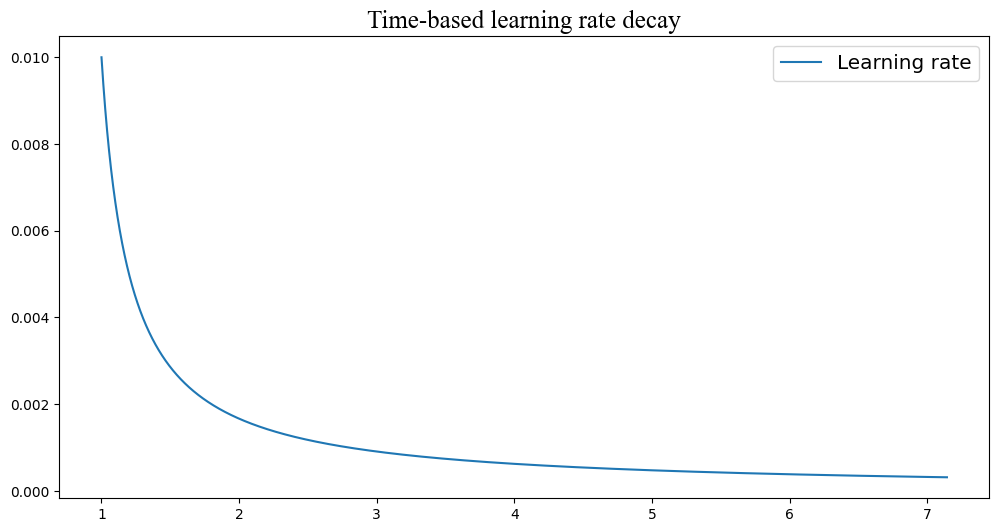

In [19]:
### Plotting the learning rate decay function
t_steps = 10 * 3072                # Total timesteps (epochs * train set size)
lr = 0.01
decay_rate = lr / 10               # Decay rate (learning_rate / epochs)
### Simulate annealing
lr_decayed = []
for t in range(t_steps):
    lr_decayed.append(time_decay(lr, t, decay_rate))
### Plot the learning rate decay
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.set_xticklabels([i for i in range(0, 10)])
ax.plot(lr_decayed, label='Learning rate')
ax.set_title('Time-based learning rate decay', fontsize=18, fontname='Times New Roman')
plt.legend(fontsize='x-large')
plt.show()

### 2.2. Modelling with TensorFlow

#### Stochastic Gradient Descent algorithm

In [20]:
### From Udacity's `training.py`

In [21]:
def sgd(params: List[tf.Variable], grads: List[tf.Variable],
        learning_rate: float, batch_size: int=1):
    """Performs the stochastic gradient descent update step.
    
    :param params: tf.Variable-like, the model parameters (weight and bias vectors).
    :param grads: tf.Variable, the computed gradients w.r.t. weight and bias vectors.
    :param learning_rate: the learning rate, i.e., value to scale the gradient update.
    :param batch_size: the number of samples factored into this gradient computation.
    :returns params: the updated model weight and bias tensor-like vectors.
    """
    # IMPLEMENT THIS FUNCTION
    
    # Consistent with stochastic gradient descent
    assert batch_size == 1
    for param, grad in zip(params, grads):
        param.assign_sub(learning_rate * grad / batch_size)
    return params

#### Logistic Regression model

In [22]:
### From J. Moran's `2022-08-27-Logistic-Regression.ipynb`

In [23]:
def model(X: tf.Tensor, W: tf.Variable, b: tf.Variable, 
          activation_fn: Callable[[tf.Tensor], tf.Tensor]) -> tf.Tensor:
    """Performs the forward step of the logistic regression model.
    
    SGD fits a linear model to the input data and target labels.
    Here we assume a logistic regression implementation with a
    softmax activation function and categorical cross-entropy loss.
    
    :param X: tf.Tensor object, a training observation
        i.e., a single HxWx3 RGB image.
    :param W: tf.Tensor object, the weight vector.
    :param b: the bias term, tf.Tensor-like object.
    :param activation_fn: a callable function which performs the softmax
        activation function and returns a probability distribution.
    returns: tf.Tensor, the softmax probability distribution.
    """

    # Compute the product between flattened input and weight vectors
    Z = tf.matmul(tf.reshape(X, shape=(-1, W.shape[0])), W)
    # Add the bias term
    Z += b
    # Return the softmax probabilities P
    return activation_fn(Z)

### 2.3. Training and validation loops

#### Custom training loop

In [24]:
def training_loop(
        train_dataset: tf.data.Dataset,
        n_classes: int,
        model: Callable[[tf.Tensor, tf.Variable, tf.Variable], tf.Tensor],
        W: tf.Variable, 
        b: tf.Variable,
        activation_fn: Callable[[tf.Tensor], tf.Tensor],
        loss_fn: Callable[[tf.Tensor, tf.Tensor], tf.Tensor], 
        optimizer: Callable[[List[tf.Variable], List[tf.Variable], float, int], 
                            List[tf.Variable]],
        accuracy_fn: Callable[[tf.Tensor, tf.Tensor], tf.Tensor],
        learning_rate: float=1e-1,
        batch_size: int=1,
        decay=False) -> Tuple[tf.Variable, tf.Variable, tf.Tensor, tf.Tensor]:
    """Performs a training loop over the input data.
    
    The logistic regression model training loop with stochastic
    gradient descent optimisation. SGD is an iterative optimisation 
    algorithm using the negative log-likelihood (cross-entropy) as
    a cost function to minimise.
    
    :param train_dataset: tf.data.Dataset, collection of tensor-like objects
        encapsulating the underlying structure of the training data.
    :param n_classes: int, the number of distinct classes in the dataset. 
    :param model: a callable function which computes the forward step of the
        logistic regression model.
    :param W: tf.Variable, a tensor-like vector of model weight values.
    :param b: tf.Variable, a tensor-like object with model bias value.
    :param activation_fn: a callable function which performs the softmax
        activation function and returns a probability distribution.
    :param loss_fn: a callable function which computes the cross-entropy loss for
        a single observation (returns the negative log-likelihood scalar value).
    :param optimizer: a callable function which performs the stochastic gradient
        descent weight update step.
    :param accuracy_fn: a callable function which computes the average
        classification accuracy.
    :param learning_rate: float, the learning rate hyperparameter to use.
    :param batch_size: int, the batch size indicating the number of training
        samples to process (should be 1 for stochastic gradient descent).
    :param decay: if True, the learning rate is anealed at each step.
    :returns: tuple, updated weight and bias tensors and two training metrics.
    """
    
    # Get number of training samples in dataset
    n_samples = len(train_dataset)
    # Consistent with SGD implementation
    assert batch_size == 1
    # Store the per-sample metrics
    accuracies = []
    losses = []
    # Step counter (to be later used with LR schedule)
    t_step = 0
    for X_train, y_train in train_dataset:
        with tf.GradientTape() as tape:
            # IMPLEMENT THIS FUNCTION

            # Scaling the input RGB image data
            X_train /= 255.0
            # Perform the forward pass
            y_hat = model(X_train, W, b, activation_fn)
            # One-hot encode the true class label
            y_one_hot = tf.one_hot(y_train, n_classes)
            # Calculate the per-sample cross-entropy loss value
            neg_log_likelihood = loss_fn(y_one_hot, y_hat)
            # Should be scalar value for SGD
            assert neg_log_likelihood.shape == tf.TensorShape([])
            losses.append(neg_log_likelihood)
        # Compute the per-sample gradients w.r.t. model weights/feature vector
        # Here our gradient vector is a generalised Jacobian matrix
        grads = tape.gradient(neg_log_likelihood, [W, b])
        if decay:
            # Using a time-based decay learning rate schedule
            learning_rate = time_decay(lr=learning_rate, t=t_step, decay=0.01)
        # Get new model weight values updated with stochastic gradient descent
        W_p, b_p = optimizer([W, b], grads, learning_rate, batch_size)
        # Update the model weights
        W, b = W_p, b_p
        # Calculate the accuracy of this prediction
        pred_acc = accuracy_fn(y_train, y_hat)
        accuracies.append(pred_acc)
        # Increment the step counter
        t_step += 1
    # Compute the mean average accuracy and cross-entropy loss for this epoch
    mean_acc = tf.math.reduce_mean(accuracies)
    mean_loss = tf.math.reduce_mean(losses)
    # Return the updated weight and bias vectors and metrics from ths epoch
    return W, b, mean_loss, mean_acc

#### Custom validation loop

In [25]:
def validation_loop(
        val_dataset: tf.data.Dataset, 
        model: Callable[[tf.Tensor, tf.Variable, tf.Variable], tf.Tensor],
        activation_fn: Callable[[tf.Tensor, tf.Tensor], tf.Tensor],
        accuracy_fn: Callable[[tf.Tensor, tf.Tensor], tf.Tensor], 
        W: tf.Tensor, 
        b: tf.Tensor) -> tf.Tensor:
    """Performs a validation loop over the input data.
    
    Average classification accuracy is computed across samples as the
    number of true predictions over the total number of predictions made.
    
    :param val_dataset: tf.data.Dataset, the set of all validation observations.
    :param model: a callable function which computes the forward step of the
        logistic regression model.
    :param activation_fn: a callable function which performs the softmax
        activation function and returns a probability distribution.
    :param accuracy_fn: a callable function which computes the average
        classification accuracy.
    :param W: tf.Variable, a tensor-like vector of trained model weight values.
    :param b: tf.Variable, a tensor-like object of trained model bias values.
    returns: tf.Tensor, average classification accuracy on validation dataset.
    """
    # IMPLEMENT THIS FUNCTION
    
    accuracies = []
    for X_val, y_val in val_dataset:
        # Scaling the input RGB image data
        X_val /= 255.0
        # Perform the forward pass with trained parameters
        y_hat = model(X_val, W, b, activation_fn)
        # Calculate the per-sample classification accuracy
        acc = accuracy_fn(y_val, y_hat)
        accuracies.append(acc)
    mean_acc = tf.math.reduce_mean(accuracies)
    return mean_acc

### 2.4. Evaluation on the GTSRB dataset

#### Considerations for our input data

In [26]:
### Defining our input image specs

In [27]:
image_size = (32, 32)          # Each RGB image has 32x32 px resolution
n_features = (32 * 32) * 3     # Each pixel value is considered an attribute (feature)
batch_size = 1                 # Using batch size of 1 for stochastic gradient descent

The following `get_datasets()` method returns a tuple of [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) instances containing the training and validation datasets, respectively.

In [28]:
### From Udacity's `dataset.py`

In [29]:
def get_datasets(imdir: str) -> tuple:
    """Return the training and validation datasets.
    
    :param imdir: absolute path to the directory where the data is stored in.
    :returns: (train_dataset, validation_dataset), tuple of tf.data.Dataset instances.
    """
    
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                        imdir,
                        labels='inferred',
                        label_mode='int',
                        color_mode='rgb',
                        batch_size=batch_size,
                        image_size=image_size,
                        shuffle=True,
                        seed=123,
                        validation_split=0.1,
                        subset='training',
    )
    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                        imdir,
                        labels='inferred',
                        label_mode='int',
                        color_mode='rgb',
                        batch_size=batch_size,
                        image_size=image_size,
                        shuffle=True,
                        seed=123,
                        validation_split=0.1,
                        subset='validation',
    )
    return train_dataset, validation_dataset

In [30]:
### Getting the training and validation data

In [31]:
imdir = os.path.join(DIR_SRC, 'GTSRB/Final_Training/Images')

In [32]:
train_dataset, validation_dataset = get_datasets(imdir)

Found 4300 files belonging to 43 classes.
Using 3870 files for training.


2023-08-17 01:13:20.860257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-17 01:13:20.860281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 4300 files belonging to 43 classes.
Using 430 files for validation.


In [33]:
### Plotting fifteen images and their class labels

2023-08-17 01:13:21.362261: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


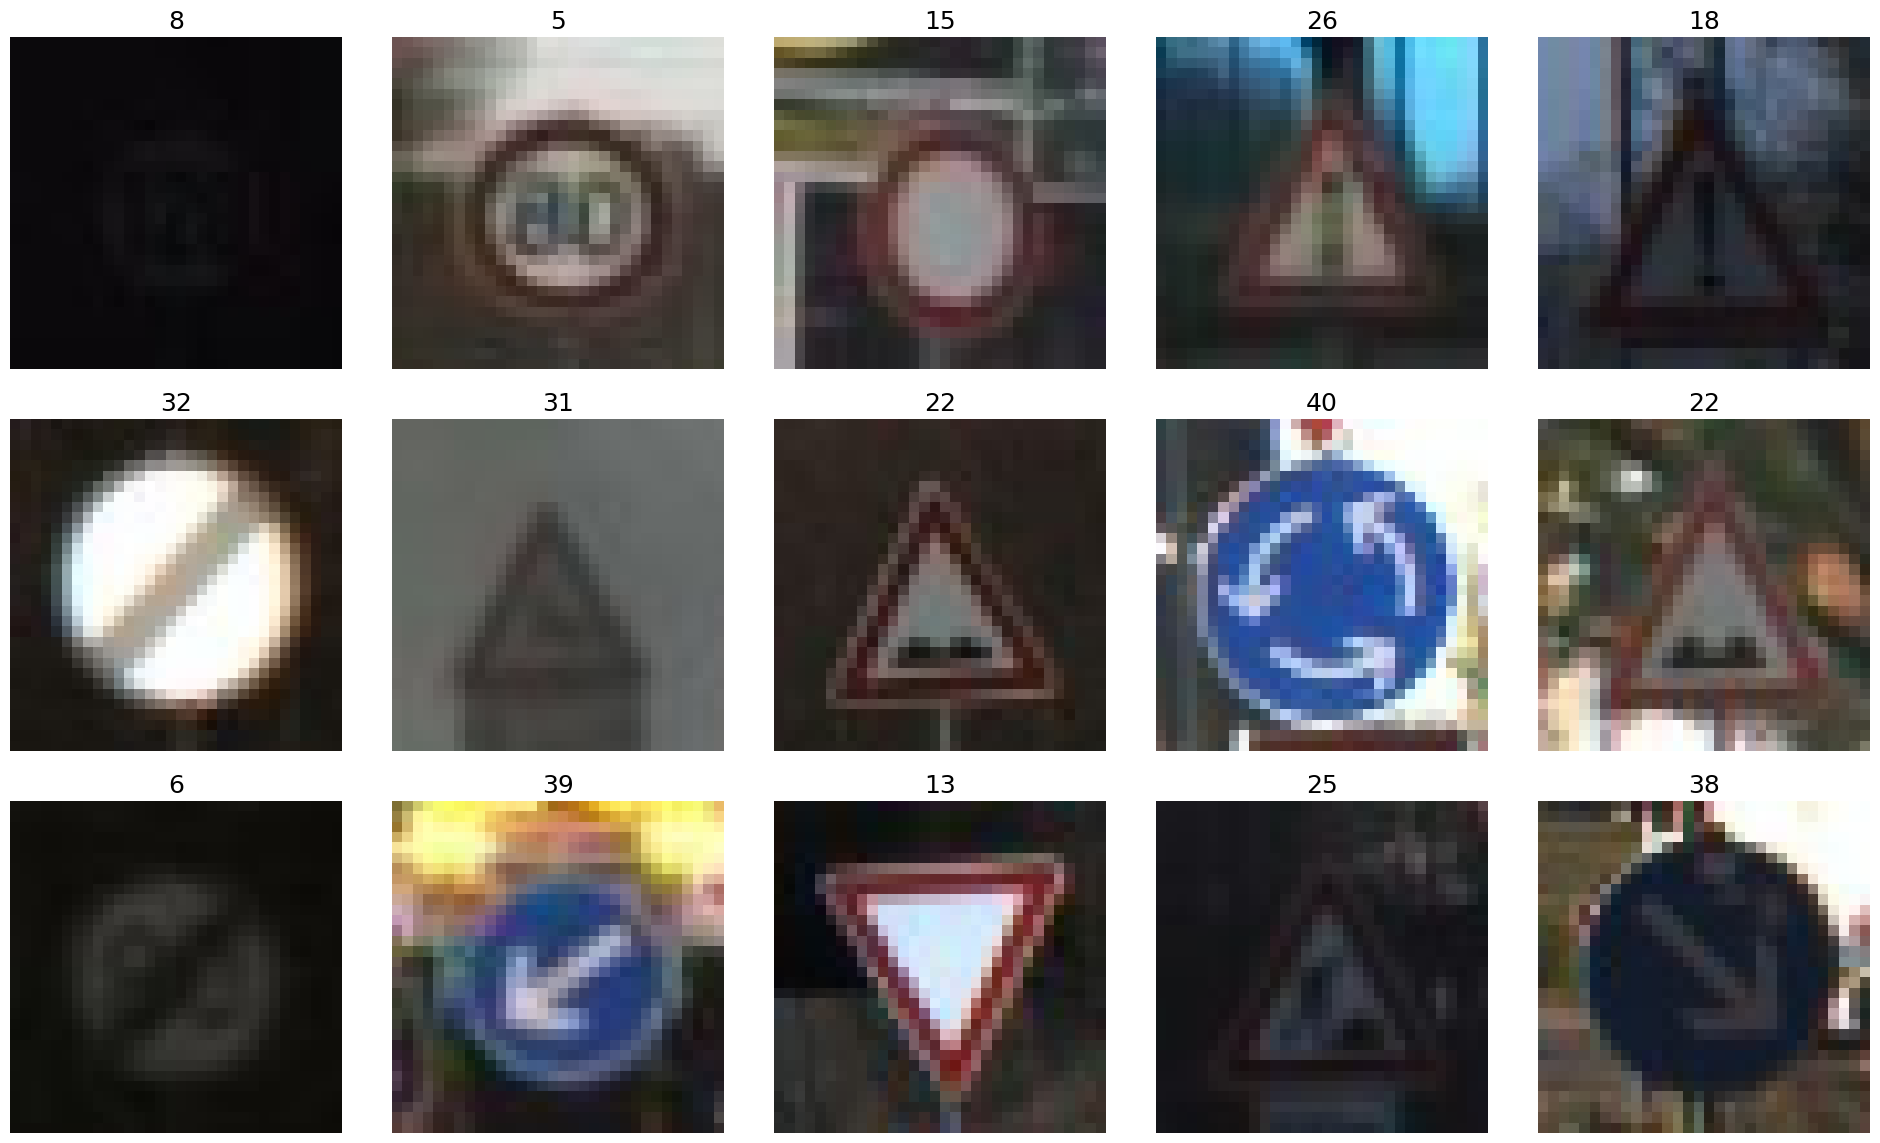

In [34]:
train_iter = iter(train_dataset)
fig = plt.figure(figsize=(24,24))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 5), axes_pad=0.5)
### Plotting images in dataset
for i, (image, label) in enumerate(train_dataset.take(15)):
    grid.axes_all[i].set_title(label=label.numpy()[0].astype('str'), fontsize=18)
    grid[i].imshow(image.numpy().reshape(32,32,3).astype('uint8'))
    grid[i].axis('off')
plt.savefig(os.path.join(DIR_OUT, '2022-08-29-Output-1-GTSRB-Images-Subset.png'))
plt.show()

#### Putting it all together

##### Initialising input/output data parameters

In [35]:
### Number of features (pixel values) in a single image
len(train_iter.get_next()[0].numpy().flatten())

3072

In [36]:
### Defining input and output tensor parameters
input_name = 'input_GTSRB_image'
num_inputs = n_features     # Each input is a flattened 32x32x3 RGB image array
num_outputs = 43            # There are 43 distinct classes in GTSRB
output_name = 'output_categorical'

##### Initialising model parameters

In [37]:
### Defining the model parameters

In [38]:
### Defining model parameters
model_name = 'LogisticRegressionModel_SGD'
### Defining model hyperparameters
epochs = 10                 # Number of complete passes over the training data
batch_size = 1              # Number of samples to compute gradient with
learning_rate = 1e-2        # Starting with a static (fixed) learning rate
decay = True                # If True, learning rate is annealed on each iter.    
### Defining model custom functions
activation_fn = softmax
loss_fn = cross_entropy
accuracy_fn = accuracy
optimizer = sgd
model_params = {'model_name': model_name, 'imdir': imdir,
                'num_inputs': num_inputs, 'input_name': input_name,
                'num_outputs': num_outputs, 'output_name': output_name,
                'learning_rate': learning_rate, 'epochs': epochs,
                'batch_size': batch_size, 'activation_fn': activation_fn,
                'loss_fn': loss_fn, 'accuracy_fn': accuracy_fn,
                'optimizer': sgd, 'decay': decay
                }

We will use the TensorFlow built-in [`tf.Variable`](https://www.tensorflow.org/api_docs/python/tf/Variable?hl=en) tensor object to distinguish our trainable model parameters (weight, bias vectors) from otherwise static tensor objects. These `tf.Variable` objects maintain a shared, persistent state and therefore come with a few useful operations (e.g., [`assign_sub()`](https://www.tensorflow.org/api_docs/python/tf/Variable#assign_sub) method) that we will use during training to manipulate their values. Another nice feature of the `tf.Variable` is that they are automatically traced and watched during the `tf.GradientTape` steps.

In [39]:
### Initialising the model variables (weights and bias vectors)
W = tf.Variable(tf.random.normal(shape=(model_params['num_inputs'], 
                                        model_params['num_outputs']), 
                                 mean=0, 
                                 stddev=0.01
                                )
)
b = tf.Variable(tf.zeros(model_params['num_outputs']))

##### Performing the training and validation loops

In [40]:
### From Udacity's `training.py`

In [41]:
def get_module_logger(mod_name):
    ### Setting up the console logger and formatter
    logger = logging.getLogger(mod_name)
    if not logger.hasHandlers():
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)
        ### Prevent messages going to root handler
        logger.propagate = False
    return logger

In [42]:
### Getting the console logger
logger = get_module_logger(model_params['model_name'])
logger.info(f"\nTraining for {model_params['epochs']} epochs " +
            f"using '{model_params['imdir']}' data")

2023-08-17 01:13:22,431 INFO     
Training for 10 epochs using 'data/GTSRB/Final_Training/Images' data


In [43]:
### Run training and validation loop

In [44]:
### Store the training and validation metrics for both trials
accuracies_train = []
losses_train = []
accuracies_val = []
### Preparing learning rate schedule
lr = model_params['learning_rate']
n_samples = len(train_dataset)
### Run two trials; one with learning rate decay, one with fixed learning rate
for trial_number, decay_trial in enumerate([False, True]):
    logger.info(f'\n------ Trial {trial_number + 1} of 2, ' + 
                f'decay learning rate: {decay_trial} ------')
    ### Increase the initial learning rate for decay trial
    if decay_trial:
        lr = 0.1
    ### Reset the model weights
    W = tf.Variable(tf.random.normal(shape=(model_params['num_inputs'], 
                                            model_params['num_outputs']), 
                                     mean=0, 
                                     stddev=0.01)
    )
    b = tf.Variable(tf.zeros(model_params['num_outputs']))
    ### Store the per-epoch metrics for each trial run
    accuracy_train = []
    accuracy_val = []
    loss_train = []
    ### Performing the training and validation epoch
    for epoch in range(1, model_params['epochs']+1):
        logger.info(f'\nEpoch: {epoch}')
        ### Shuffle the training dataset at every epoch
        train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset),
                                            reshuffle_each_iteration=True
        )
        ### Perform stochastic gradient descent over training data
        W_p, b_p, train_loss, train_acc = training_loop(
                                train_dataset=train_dataset, 
                                n_classes=model_params['num_outputs'],
                                model=model, 
                                W=W,
                                b=b,
                                activation_fn=model_params['activation_fn'],
                                loss_fn=model_params['loss_fn'],
                                optimizer=model_params['optimizer'],
                                accuracy_fn=model_params['accuracy_fn'],
                                learning_rate=model_params['learning_rate'],
                                batch_size=model_params['batch_size'],
                                decay=decay_trial
        )
        ### Decay the learning rate for this epoch (restores state from loop)
        if decay_trial:
            lr = time_decay(lr=lr, t=n_samples*epoch, decay=0.01)
        ### Update the model variables (weights and bias vectors)
        W = W_p
        b = b_p
        ### Log the mean average training loss and accuracy for this epoch
        logger.info(f'\nMean training loss: {train_loss.numpy():.4f}, ' +
                    f'Mean training accuracy: {train_acc.numpy():.4f}')
        accuracy_train.append(train_acc.numpy())
        loss_train.append(train_loss.numpy())
        ### Compute validation set accuracy
        val_acc = validation_loop(
                        val_dataset=validation_dataset,
                        model=model,
                        activation_fn=model_params['activation_fn'],
                        accuracy_fn=model_params['accuracy_fn'],
                        W=W,
                        b=b
        )
        ### Log the mean average validation accuracy for this epoch
        logger.info(f'\nMean validation accuracy: {val_acc.numpy():.4f}')
        accuracy_val.append(val_acc.numpy())
    ### Append the trial metrics to lists
    accuracies_train.append(np.array(accuracy_train))
    accuracies_val.append(np.array(accuracy_val))
    losses_train.append(np.array(loss_train))

2023-08-17 01:13:22,441 INFO     
------ Trial 1 of 2, decay learning rate: False ------
2023-08-17 01:13:22,443 INFO     
Epoch: 1
2023-08-17 01:14:06,023 INFO     
Mean training loss: 3.5600, Mean training accuracy: 0.2186
2023-08-17 01:14:07,049 INFO     
Mean validation accuracy: 0.4907
2023-08-17 01:14:07,049 INFO     
Epoch: 2
2023-08-17 01:14:47,150 INFO     
Mean training loss: 2.0007, Mean training accuracy: 0.5171
2023-08-17 01:14:48,131 INFO     
Mean validation accuracy: 0.4558
2023-08-17 01:14:48,131 INFO     
Epoch: 3
2023-08-17 01:15:27,736 INFO     
Mean training loss: 1.5099, Mean training accuracy: 0.6276
2023-08-17 01:15:28,721 INFO     
Mean validation accuracy: 0.6140
2023-08-17 01:15:28,721 INFO     
Epoch: 4
2023-08-17 01:16:08,513 INFO     
Mean training loss: 1.2252, Mean training accuracy: 0.7049
2023-08-17 01:16:09,502 INFO     
Mean validation accuracy: 0.7302
2023-08-17 01:16:09,503 INFO     
Epoch: 5
2023-08-17 01:16:49,111 INFO     
Mean training loss: 1.

In [45]:
# The weight vectors (for the annealed LR trial)
W

<tf.Variable 'Variable:0' shape=(3072, 43) dtype=float32, numpy=
array([[-0.01285897,  0.0091654 ,  0.00484492, ..., -0.00276208,
         0.00405208,  0.00110066],
       [ 0.01425426,  0.00453303,  0.00094287, ..., -0.00394818,
        -0.00665639,  0.00083563],
       [-0.00279941,  0.00650835, -0.00699903, ..., -0.00524821,
        -0.00362241,  0.00899949],
       ...,
       [ 0.0006762 , -0.00415063, -0.00901125, ..., -0.01576174,
         0.00341058, -0.00618723],
       [-0.01380175, -0.00391142,  0.0033085 , ...,  0.00611445,
        -0.00111976, -0.0006205 ],
       [ 0.00591082, -0.00781643, -0.00781596, ..., -0.01448122,
        -0.0056467 , -0.00092948]], dtype=float32)>

In [46]:
# The bias values (for the annealed LR trial)
b

<tf.Variable 'Variable:0' shape=(43,) dtype=float32, numpy=
array([-0.00999946, -0.00401535, -0.00565284,  0.00218907,  0.0023073 ,
        0.00899395,  0.02230978,  0.01204374,  0.00792616, -0.0134264 ,
        0.00142265, -0.01363434, -0.01306847, -0.00093405, -0.00263941,
       -0.00810691, -0.00429059, -0.00638453, -0.00056793,  0.01206089,
        0.0254173 , -0.00361344, -0.011991  ,  0.00587103, -0.00319223,
       -0.00763892,  0.00027015, -0.00495885,  0.00176886,  0.0098786 ,
        0.01812224,  0.00344358, -0.00795115, -0.00507055, -0.00014047,
       -0.00026844, -0.00288856, -0.00537142, -0.0003413 , -0.00475872,
       -0.01578912,  0.01148214,  0.01118717], dtype=float32)>

##### Visualising the results

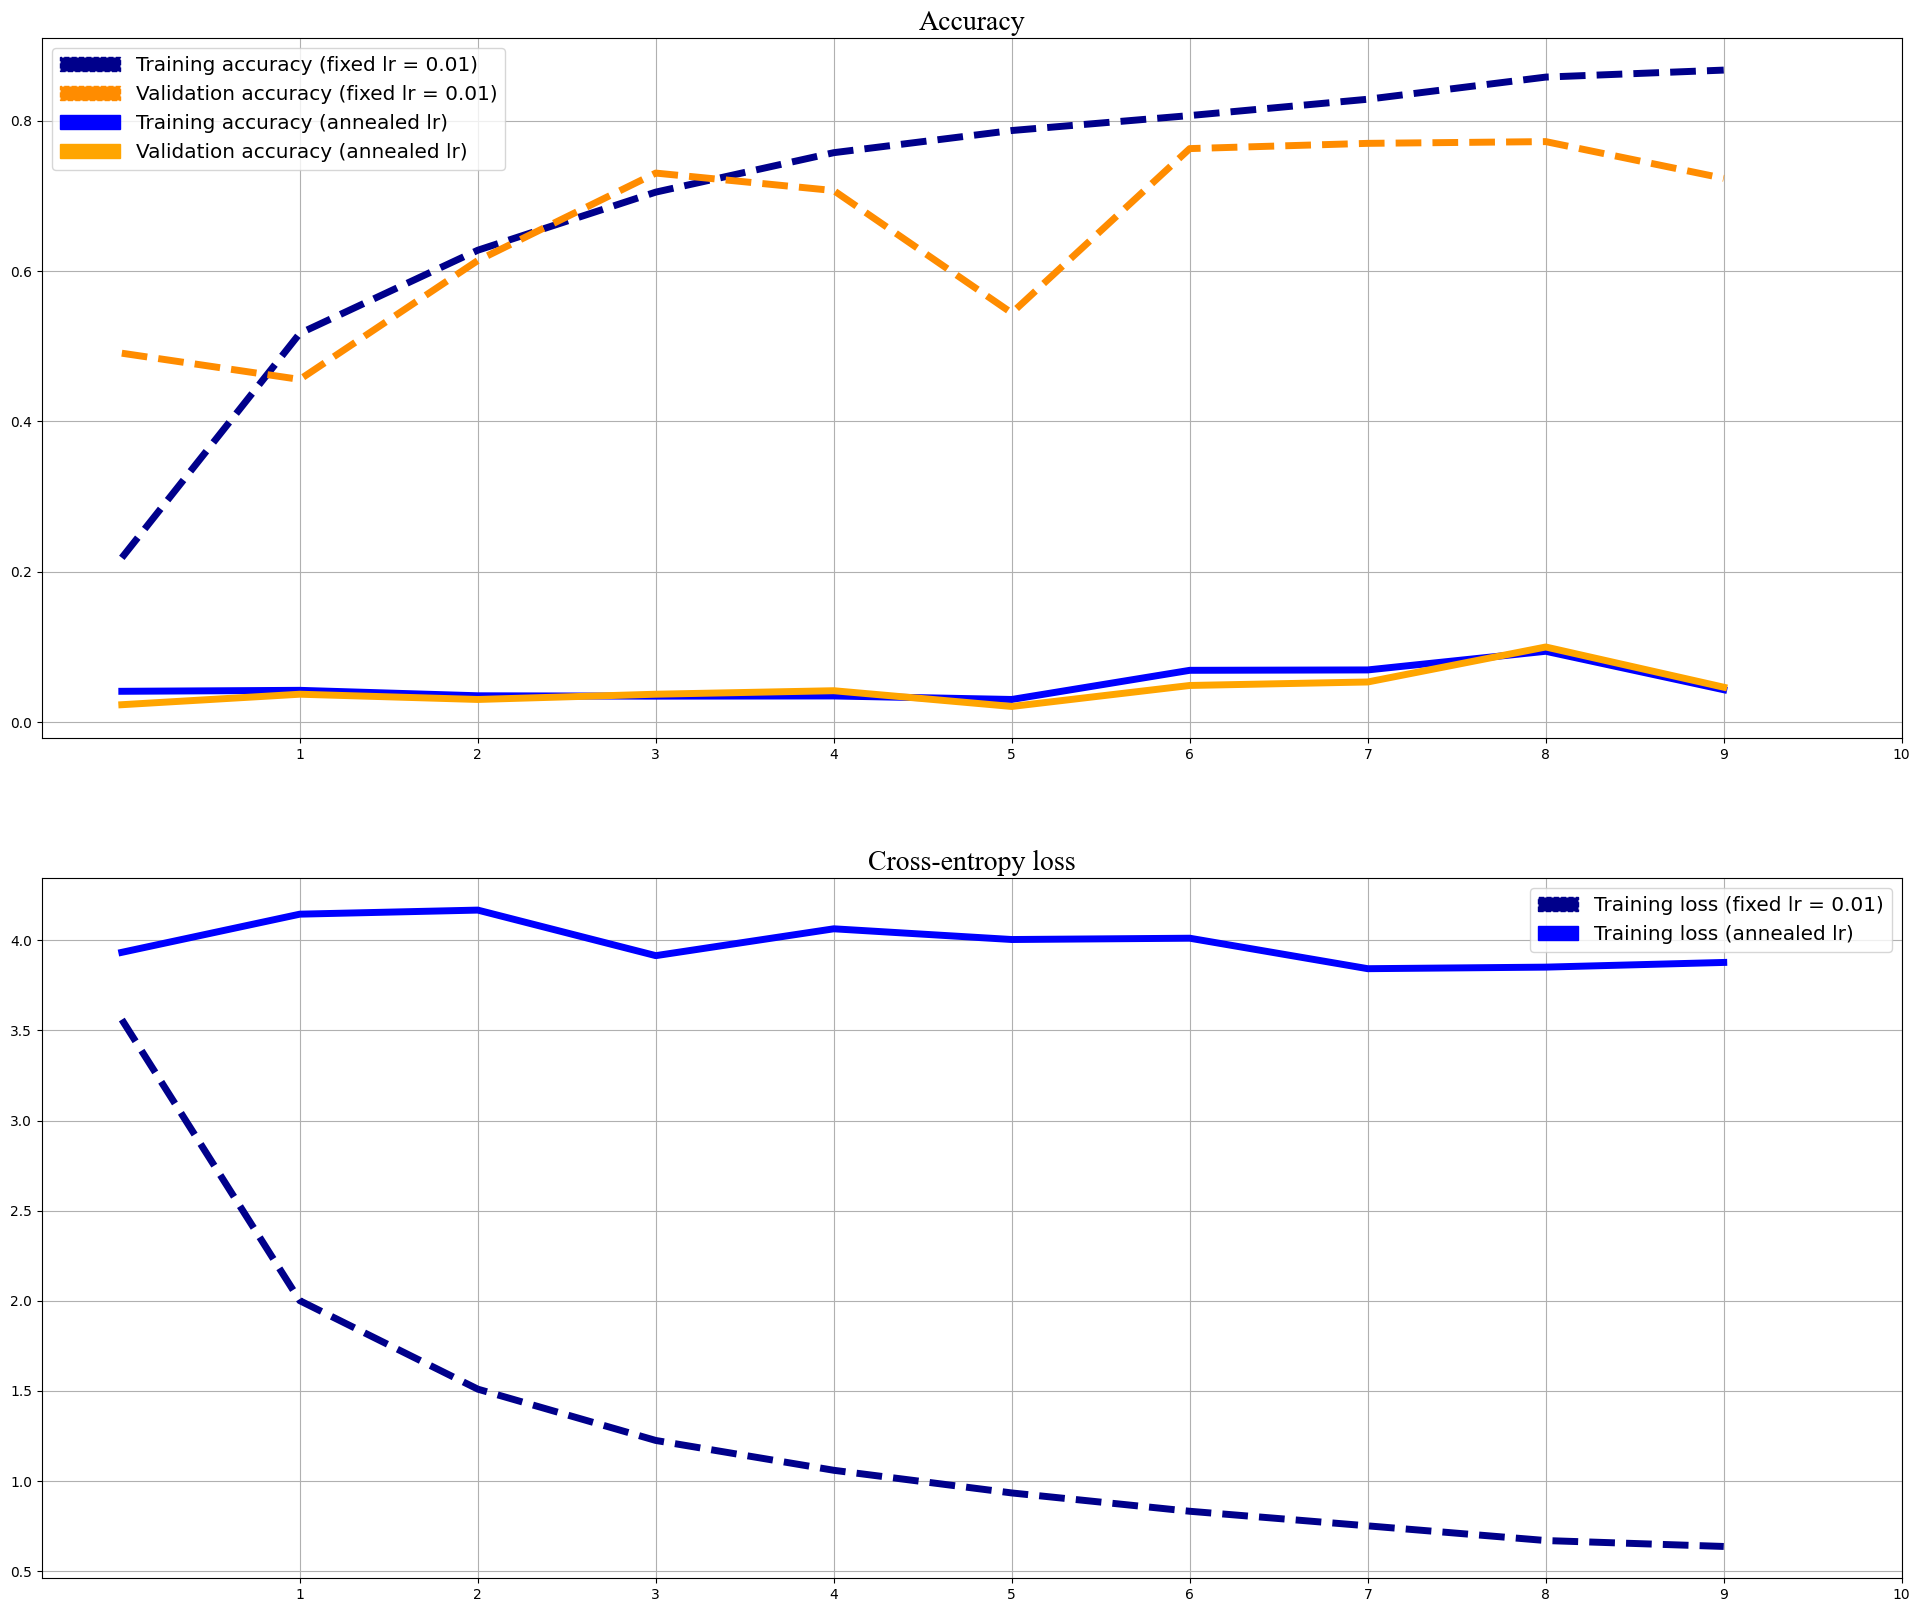

In [47]:
n_epochs = list(range(1,model_params['epochs']+1))
### Creating the accurcy metric patches
ta1 = patches.Patch(color='darkblue', linestyle='--', 
    label=f"Training accuracy (fixed lr = {model_params['learning_rate']})")
va1 = patches.Patch(color='darkorange', linestyle='--', 
    label=f"Validation accuracy (fixed lr = {model_params['learning_rate']})")
ta2 = patches.Patch(color='blue', linestyle='-', 
                    label='Training accuracy (annealed lr)')
va2 = patches.Patch(color='orange', linestyle='-', 
                    label='Validation accuracy (annealed lr)')
pa = [ta1, va1, ta2, va2]
### Creating the loss metric patches
lo1 = patches.Patch(color='darkblue', linestyle='--', 
        label=f"Training loss (fixed lr = {model_params['learning_rate']})")
lo2 = patches.Patch(color='blue', linestyle='-', 
        label=f"Training loss (annealed lr)")
pl = [lo1, lo2]
### Plotting the metrics for fixed and annealed LR trials
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(24,20))
ax1.plot(accuracies_train[0], pa[0].get_linestyle(), c=pa[0].get_ec(), lw=5)
ax1.plot(accuracies_val[0], pa[1].get_linestyle(), c=pa[1].get_ec(), lw=5)
ax1.plot(accuracies_train[1], pa[2].get_linestyle(), c=pa[2].get_ec(), lw=5)
ax1.plot(accuracies_val[1], pa[3].get_linestyle(), c=pa[3].get_ec(), lw=5)
ax1.set_xticks(n_epochs)
ax1.grid('on')
ax1.set_title(label='Accuracy', fontname='Times New Roman', fontsize=20)
ax1.legend(handles=pa, fontsize='x-large', handlelength=3)
ax2.plot(losses_train[0], pl[0].get_linestyle(), c=pl[0].get_ec(), lw=5)
ax2.plot(losses_train[1], pl[1].get_linestyle(), c=pl[1].get_ec(), lw=5)
ax2.set_xticks(n_epochs)
ax2.grid('on')
ax2.set_title(label='Cross-entropy loss', fontname='Times New Roman', fontsize=20)
ax2.legend(handles=pl, fontsize='x-large')
plt.savefig(os.path.join(DIR_OUT, '2022-08-29-Output-2-Visualising-Metrics.png'))
plt.show()

## 3. Closing Remarks

##### Alternatives
* Use other evaluation metrics (e.g., precision, recall, F1-score, etc.);
* Explore other hyperparameter settings (e.g., increasing num. epochs, changing value of learning rate, etc.).


##### Extensions of task
* Implement a learning rate shedule (decreases learning rate over training);
* Use a different TensorFlow API design pattern (e.g., [Sequential](https://www.tensorflow.org/guide/keras/sequential_model), [Subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)).

## 4. Future work
- ✅ Visualise metrics across epochs;
- ✅ Implement a learning rate schedule (e.g., time-based decay — see [Exercise 1.5.3](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-5-3-Learning-Rate-Schedules/2022-09-28-Learning-Rate-Schedules.ipynb));
- ✅ Perform EDA of GTSRB dataset (see [Exercise 1.4.2](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-4-2-Building-Custom-CNNs/2022-09-12-Building-Custom-Convolutional-Neural-Networks.ipynb));
- ⬜️ Encapsulate model + functions with TensorFlow Keras [Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

## Credits

This assignment was prepared by Thomas Hossler and Michael Virgo et al., Winter 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).

References
* [1] Parr, T., Howard, J. The Matrix Calculus You Need For Deep Learning. arXiv (2018). [doi:10.48550/arXiv.1802.01528](https://arxiv.org/abs/1802.01528).
* [2] Stallkamp, J. et al. Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition. Neural Networks. 32:323-332. [doi:10.1016/j.neunet.2012.02.016](https://doi.org/10.1016/j.neunet.2012.02.016).

Helpful resources:
   * [An overview of gradient descent optimization algorithms | S. Ruder](https://ruder.io/optimizing-gradient-descent/)
   * [The Matrix Calculus You Need for Deep Learning by T. Parr and J. Howard | explained.ai](https://arxiv.org/abs/1802.01528)
   * [Derivative, Gradient and Jacobian | Deep Learning Wizard](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/derivative_gradient_jacobian/)
   * [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning by S. Lau | Medium](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)